# Exercises

- The dataset for these exercises lives in the Codeup Data Science MySQL Server. The database name is curriculum_logs.

- Go through the lesson commenting code, adding docstrings, and adding markdown to support what is happening.

In [6]:
# tabular manipulation:
import numpy as np
import pandas as pd

# visualization:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# environment:
from env import host, user, password

In [4]:
def get_db_url(db_name):
    '''
    This function uses my info from my env file to
    create a connection url to access the Codeup db.
    '''
    from env import host, user, password
    return f'mysql+pymysql://{user}:{password}@{host}/{db_name}'

In [7]:
url = get_db_url("curriculum_logs")

sql = """
select *
from logs
"""

df = pd.read_sql(sql, url, index_col="user_id")
df.head()

,date,time,path,cohort_id,ip
user_id,,,,,
1,2018-01-26,09:55:03,/,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,8.0,97.105.19.61
1,2018-01-26,09:56:05,java-ii/object-oriented-programming,8.0,97.105.19.61
1,2018-01-26,09:56:06,slides/object_oriented_programming,8.0,97.105.19.61
2,2018-01-26,09:56:24,javascript-i/conditionals,22.0,97.105.19.61


In [8]:
#turn date into index and datetime dtype
df.date = pd.to_datetime(df.date)
df = df.set_index(df.date)

In [9]:
# resample daily counts for number of page views

pages = df['path'].resample('d').count()
pages.head()

date
2018-01-26    572
2018-01-27    230
2018-01-28    170
2018-01-29    830
2018-01-30    652
Freq: D, Name: path, dtype: int64

<AxesSubplot:xlabel='date'>

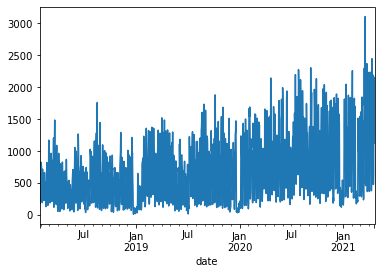

In [11]:
#visualize
pages.plot()

### EMA

<AxesSubplot:xlabel='date'>

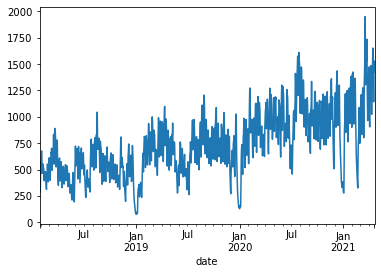

In [12]:
# 7 day EMA
ema_7d = pages.ewm(span = 7).mean()
ema_7d.plot()

<AxesSubplot:xlabel='date'>

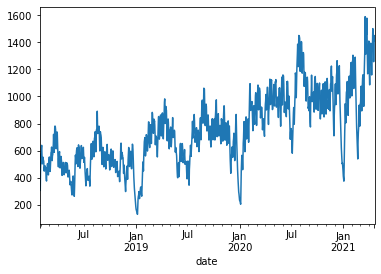

In [13]:
# 14 days EMA
ema_14d = pages.ewm(span = 14).mean()
ema_14d.plot()

<AxesSubplot:xlabel='date'>

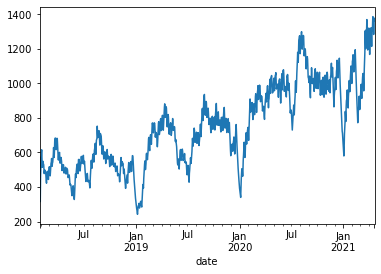

In [14]:
# 30 days EMA
ema_30d =pages.ewm(span = 30).mean()
ema_30d.plot()

<AxesSubplot:xlabel='date'>

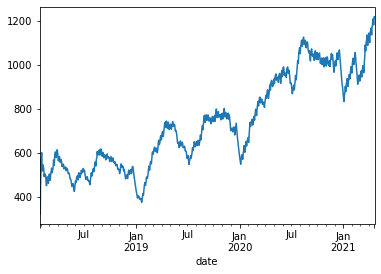

In [15]:
# 90 days EMA
ema_90d =pages.ewm(span = 90).mean()
ema_90d.plot()

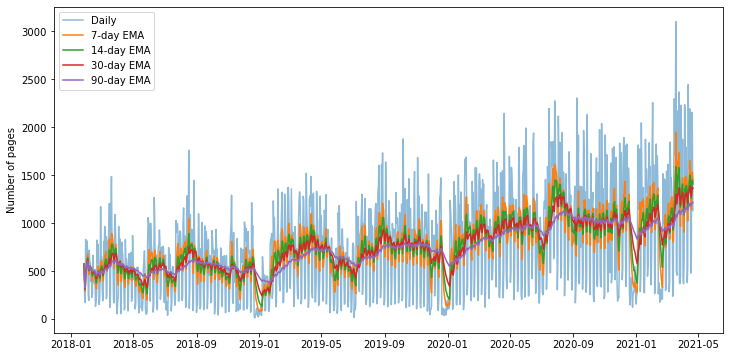

In [16]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(pages.index, pages, label='Daily', alpha=.5)

ax.plot(pages.index, ema_7d, label = '7-day EMA')
ax.plot(pages.index, ema_14d, label = '14-day EMA')
ax.plot(pages.index, ema_30d, label = '30-day EMA')
ax.plot(pages.index, ema_90d, label = '90-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

### Calculate Bollinger Bands

In [17]:
#calculate midband
span = 30

midband= pages.ewm(span=30).mean()
midband.head()

date
2018-01-26    572.000000
2018-01-27    395.300000
2018-01-28    315.139578
2018-01-29    457.002386
2018-01-30    501.369064
Freq: D, Name: path, dtype: float64

In [18]:
std = pages.ewm(span=30).std()

In [19]:
#calculate upper and lower using 3std
ub = midband+ std * 3
lb = midband- std *3
ub.head()

date
2018-01-26            NaN
2018-01-27    1120.791557
2018-01-28     956.773991
2018-01-29    1406.405897
2018-01-30    1354.808245
Freq: D, Name: path, dtype: float64

In [20]:
#concat pages, midband, lb and ub
my_df =pd.concat([pages, midband, ub, lb], axis=1)
my_df.columns= ['pages', 'midband', 'ub','lb']
my_df.head()

,pages,midband,ub,lb
date,,,,
2018-01-26,572,572.000000,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557
2018-01-28,170,315.139578,956.773991,-326.494835
2018-01-29,830,457.002386,1406.405897,-492.401124
2018-01-30,652,501.369064,1354.808245,-352.070116


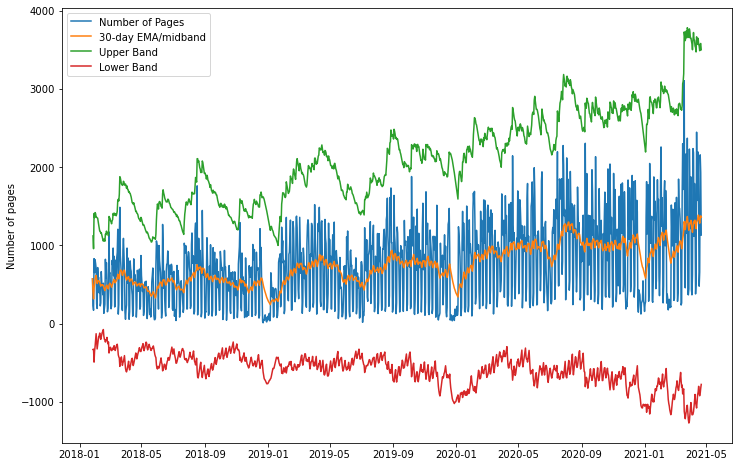

In [21]:
#plot bollinger bands
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(my_df.index, my_df.pages, label='Number of Pages')

ax.plot(my_df.index, my_df.midband, label = '30-day EMA/midband')
ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
ax.plot(my_df.index, my_df.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

In [22]:
#calculate percent of b using
## (total pages - lowerband) / (upperband-lowerband)
my_df['pct_b'] = (my_df['pages']- my_df['lb']/ (my_df['ub']- my_df['lb']))

#take a look
my_df.head() 

,pages,midband,ub,lb,pct_b
date,,,,,
2018-01-26,572,572.000000,NaN,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557,230.227564
2018-01-28,170,315.139578,956.773991,-326.494835,170.254424
2018-01-29,830,457.002386,1406.405897,-492.401124,830.259321
2018-01-30,652,501.369064,1354.808245,-352.070116,652.206265


In [23]:
#look at only probability of b greater than 1
my_df[my_df.pct_b > 1]

,pages,midband,ub,lb,pct_b
date,,,,,
2018-01-27,230,395.300000,1120.791557,-330.191557,230.227564
2018-01-28,170,315.139578,956.773991,-326.494835,170.254424
2018-01-29,830,457.002386,1406.405897,-492.401124,830.259321
2018-01-30,652,501.369064,1354.808245,-352.070116,652.206265
2018-01-31,816,562.921651,1418.090581,-292.247280,816.170871
...,...,...,...,...,...
2021-04-17,478,1325.179115,3545.216722,-894.858492,478.201541
2021-04-18,659,1282.199817,3486.733695,-922.334061,659.209190
2021-04-19,2156,1338.574023,3569.147958,-891.999913,2156.199949


### Put it all together

In [25]:
def acquire(file_name, column_names):
    '''
    this function brings in a file from csv
    and turns it into a pandas dataframe using spaces as seperators for each column
    '''
    return pd.read_csv(file_name, sep="\s", header=None, names=column_names, usecols=[0, 2, 3, 4, 5])

def prep(df, user):
    '''
    turned date into a datetime dtype and sorted by that as the index
    resampled path by day and count that as pages
    '''
    df = df[df.user_id == user]
    df.date = pd.to_datetime(df.date)
    df = df.set_index(df.date)
    pages = df['path'].resample('d').count()
    return pages

def compute_pct_b(pages, span, weight, user):
    '''
    This function takes in pages, span, weight and user
    then outputs a new df with the percentage of b
    '''
    midband = pages.ewm(span=span).mean()
    stdev = pages.ewm(span=span).std()
    ub = midband + stdev * weight
    lb = midband - stdev * weight
    bb = pd.concat([ub, lb], axis=1)
    my_df = pd.concat([pages, midband, bb], axis=1)
    my_df.columns = ['pages', 'midband', 'ub', 'lb']
    my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
    my_df['user_id'] = user
    return my_df

def plt_bands(my_df, user):
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(my_df.index, my_df.pages, label='Number of Pages, User: '+str(user))
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    ax.legend(loc='best')
    ax.set_ylabel('Number of Pages')
    plt.show()
    
def find_anomalies(df, user, span, weight):
    pages = prep(df, user)
    my_df = compute_pct_b(pages, span, weight, user)
#     plt_bands(my_df, user)
    return my_df[my_df.pct_b > 1]